In [1]:
!git clone 'https://github.com/aakashvardhan/Transformers-Collab.git'

Cloning into 'Transformers-Collab'...
remote: Enumerating objects: 546, done.
remote: Counting objects: 100% (546/546), done.
remote: Compressing objects: 100% (466/466), done.
remote: Total 546 (delta 123), reused 483 (delta 60), pack-reused 0
Receiving objects: 100% (546/546), 21.37 MiB | 20.64 MiB/s, done.
Resolving deltas: 100% (123/123), done.


In [2]:
%cd Transformers-Collab

/content/Transformers-Collab


In [3]:
!pip install torchinfo

In [4]:
from utils import (create_dataloader,
                   get_img_batch,
                   show_img,
                   patchify_img,
                   show_conv2d_feature_maps)
from config import VITConfig
import torchvision
import torch
import torch.nn as nn
from torchinfo import summary

In [5]:
config = VITConfig()

train_dataloader, test_dataloader, class_names = create_dataloader(config)

## Image Inspect

In [6]:
image, label = get_img_batch(train_dataloader)

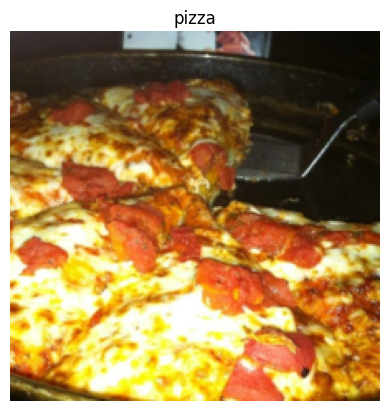

<Figure size 640x480 with 0 Axes>

In [7]:
show_img(image, label, class_names)

Number of patches per row: 14.0            
Number of patches per column: 14.0            
Total patches: 196.0            
Patch size: 16 pixels x 16 pixels


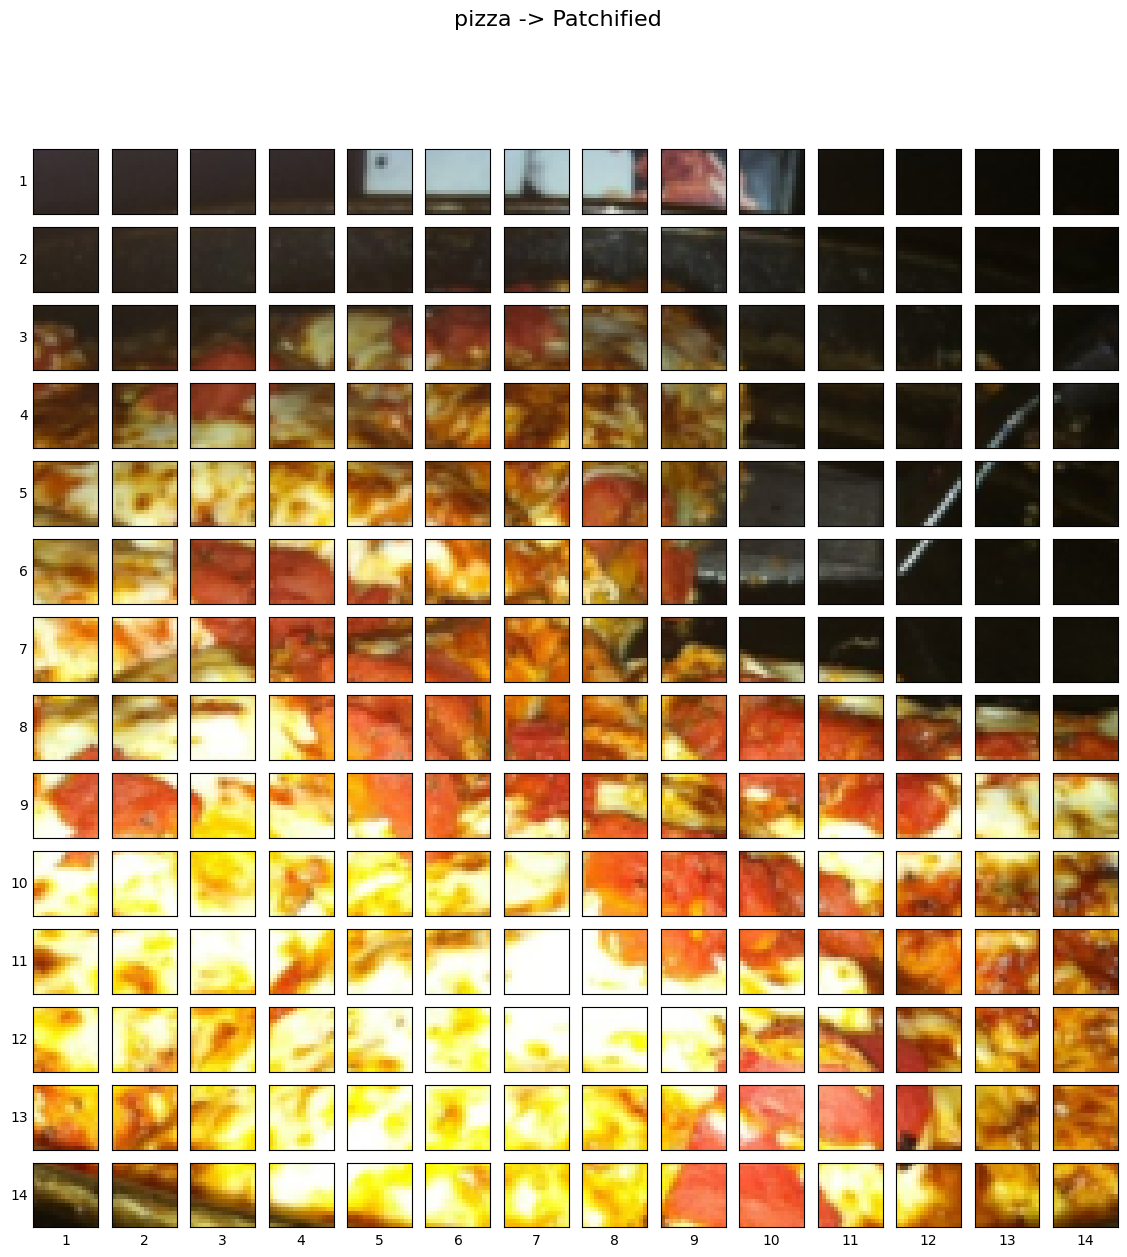

In [8]:
patchify_img(image, label, class_names, config)

Showing random convolutional feature maps from indexes: [611, 468, 94, 591, 256]


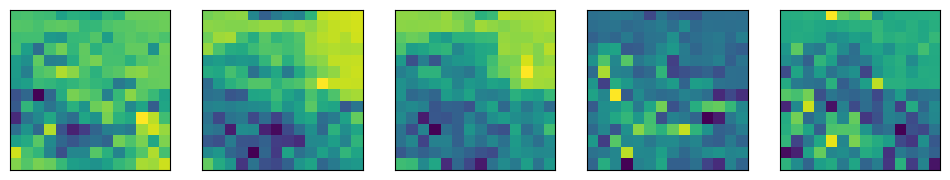

In [9]:
show_conv2d_feature_maps(image, config)

In [10]:
from utils import (get_vit_model_summary,
                   show_flattened_feature_map)


Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])
Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


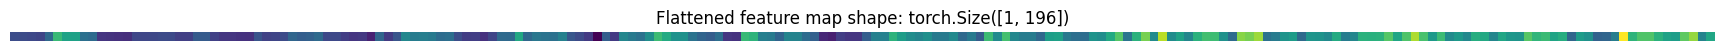

In [11]:
show_flattened_feature_map(image, config)

## Model Training

In [12]:
import sys
sys.path.append("/content/Transformers-Collab")
sys.path.append("/content/Transformers-Collab/models")

In [13]:
from models import transformer as t
from vit_engine import train

In [14]:
class_names

['pizza', 'steak', 'sushi']

In [15]:
vit = t.ViT(num_classes=len(class_names))
print(vit)

ViT(
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (patch_embedding): PatchEmbedding(
    (patcher): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (flatten): Flatten(start_dim=2, end_dim=3)
  )
  (transformer_encoder): Sequential(
    (0): TransformerEncoderBlock(
      (msa_block): Attention(
        (attention): VIT_MultiheadSelfAttentionBlock(
          (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (multihead_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
        )
      )
      (mlp_block): MLPBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dr

In [16]:
# Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(model=vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                         [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                                [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                           [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                          [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                                [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           

In [17]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [18]:
# Retrieve the first batch from the dataloader
# first_batch = next(iter(train_dataloader))
# X, y = first_batch
# X, y = X.to(config.device), y.to(config.device)  # Move to the correct device

# # Put the model in training mode
# vit.train()

# # Forward pass
# y_pred = vit(X)

# # Calculate loss
# loss = loss_fn(y_pred, y)

# # Backward pass and optimization
# optimizer.zero_grad()
# loss.backward()
# optimizer.step()

# # Optionally, print out the loss to see what's happening
# print(f"Loss for the single batch: {loss.item()}")

In [19]:
for name, module in vit.named_modules():
    pass
final_layer_name, final_layer = name, module
print(f"Final layer name: {final_layer_name}, module: {final_layer}")

Final layer name: classifier.1, module: Linear(in_features=768, out_features=3, bias=True)


In [20]:
optimizer = torch.optim.Adam(params=vit.parameters(),
                            lr=config.lr, # Base LR from Table 3 for ViT-* ImageNet-1k
                            betas=config.betas, # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                            weight_decay=config.weight_decay) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()




# # Train the model and save the training results to a dictionary
results = train(model=vit,
                    train_dataloader=train_dataloader,
                    test_dataloader=test_dataloader,
                    optimizer=optimizer,
                    loss_fn=loss_fn,
                    epochs=config.epoch,
                    device=config.device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.7025 | train_acc: 0.2695 | test_loss: 1.0182 | test_acc: 0.5417
Epoch: 2 | train_loss: 1.5276 | train_acc: 0.3438 | test_loss: 1.1550 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.1396 | train_acc: 0.4570 | test_loss: 1.6246 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.2281 | train_acc: 0.2891 | test_loss: 1.2215 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.1349 | train_acc: 0.3555 | test_loss: 1.2711 | test_acc: 0.1979


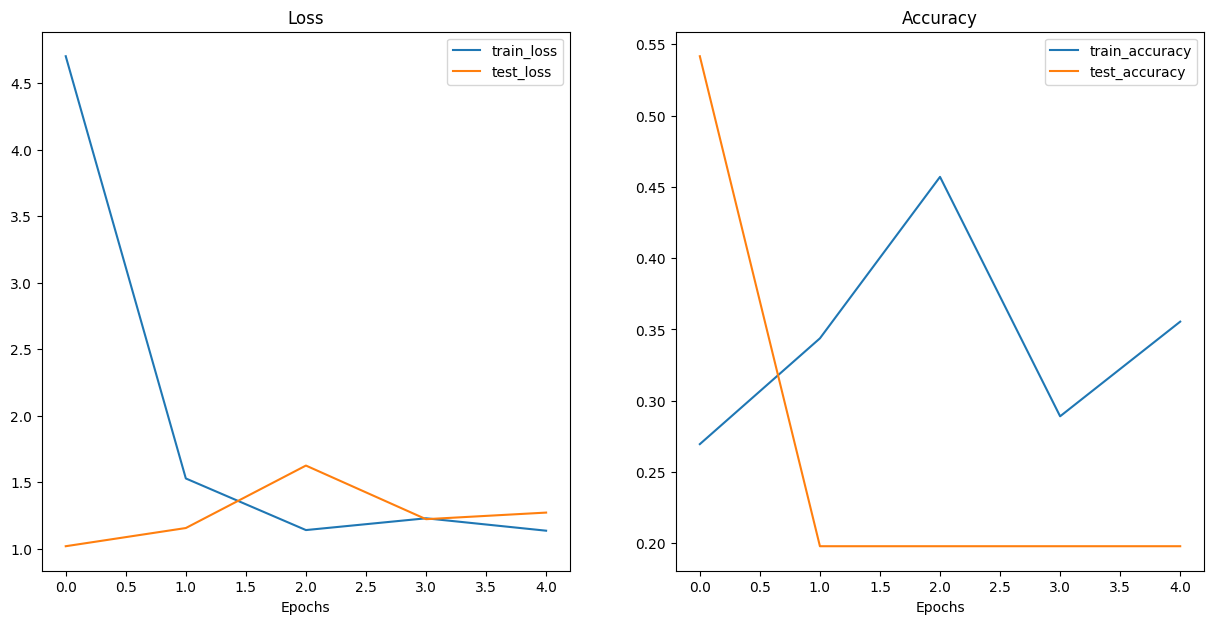

In [21]:
from evaluation_utils import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(results)

In [22]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(config.device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False


pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(config.device)
# pretrained_vit # uncomment for model output

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:06<00:00, 54.6MB/s]


In [23]:
get_vit_model_summary(pretrained_vit)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [24]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [25]:
config_updates = {'manual_transform': pretrained_vit_transforms}
config.update_config(config_updates)

# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloader(config)

In [28]:
# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
pretrained_vit_results = train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=config.epoch,
                                      device=config.device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9388 | train_acc: 0.5039 | test_loss: 0.6163 | test_acc: 0.8873
Epoch: 2 | train_loss: 0.4836 | train_acc: 0.8867 | test_loss: 0.4844 | test_acc: 0.8674
Epoch: 3 | train_loss: 0.4210 | train_acc: 0.9219 | test_loss: 0.3494 | test_acc: 0.8674
Epoch: 4 | train_loss: 0.2635 | train_acc: 0.9531 | test_loss: 0.2646 | test_acc: 0.9072
Epoch: 5 | train_loss: 0.2326 | train_acc: 0.9531 | test_loss: 0.2402 | test_acc: 0.9176


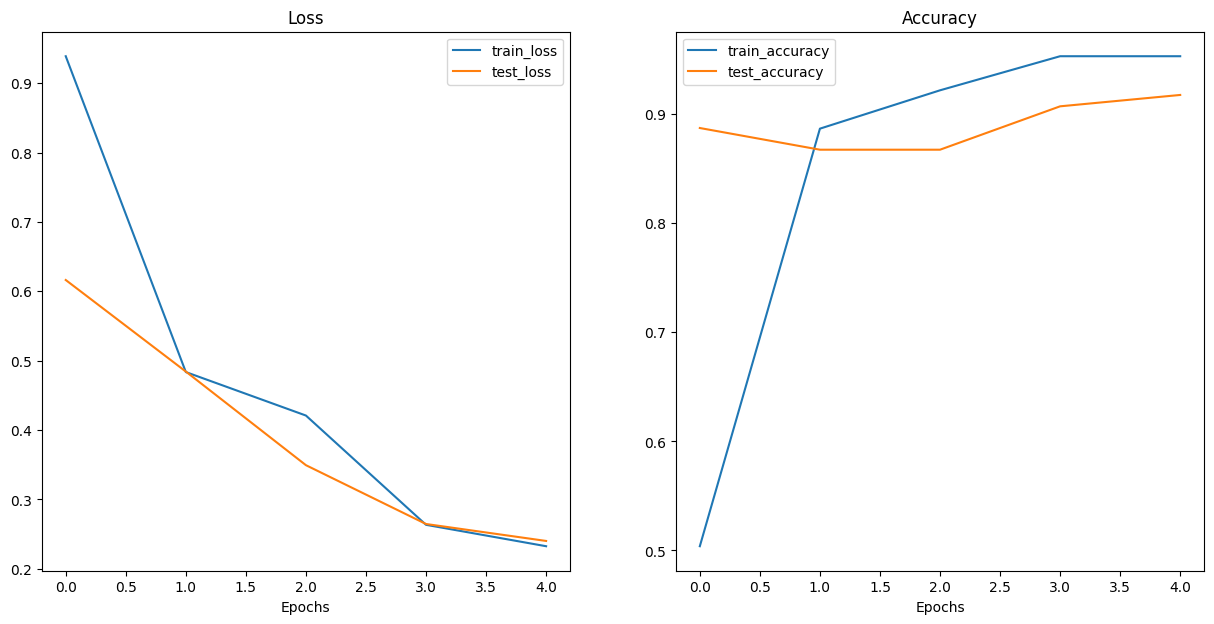

In [29]:
plot_loss_curves(pretrained_vit_results)

In [31]:
import utils

In [32]:
# Save the model
utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [33]:
!python main.py 'vit'

Traceback (most recent call last):
  File "/content/Transformers-Collab/main.py", line 10, in <module>
    from vit_engine import train, test
ImportError: cannot import name 'test' from 'vit_engine' (/content/Transformers-Collab/vit_engine.py)
